# In this notebook, we use mixed precision (mixed_bfloat16) for testing the performance and speed up compared to single precision (float32) for ANN, ResNET, and BNN in TF-MELT.

## Note that, this code is for training on CPUs only since we are utilizing the Intel AMX technology in the Intel® Xeon® processors. For our tests, we used Intel® Xeon® Platinum 8470QL CPUs with 104 cores on Kestrel (NREL's HPC Cluster).

### Pre-requisite installs after tf-melt installation

In [ ]:
!python -m pip install tensorflow-datasets matplotlib scikit-learn ipykernel codecarbon

### To check if Intel AMX Technology is available on your CPU, run the following command. If it is available, you should see an output containing these flags: `amx_bf16`, `amx_tile` and `amx_int8`. 

In [15]:
!lscpu | grep amx

Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf tsc_known_freq pni pclmulqdq dtes64 monitor ds_cpl vmx smx est tm2 ssse3 sdbg fma cx16 xtpr pdcm pcid dca sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand lahf_lm abm 3dnowprefetch cpuid_fault epb cat_l3 cat_l2 cdp_l3 invpcid_single cdp_l2 ssbd mba ibrs ibpb stibp ibrs_enhanced tpr_shadow vnmi flexpriority ept vpid ept_ad fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid cqm rdt_a avx512f avx512dq rdseed adx smap avx512ifma clflushopt clwb intel_pt avx512cd sha_ni avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves cqm_llc cqm_occup_llc cqm_mbm_total cqm_mbm_local split_lock_detect avx_vnni avx512_bf16 wbnoinvd dtherm ida arat pln pts hwp hwp_act_window hwp_pkg_req avx512vbmi umip pku ospke waitpkg 

### Next, if the CPU supports Intel AMX, to use the technology we need to set the following environment variable which will set the instruction set architecture (ISA) at the level that supports Intel AMX with both INT8 and bfloat16.

In [16]:
import os
os.environ["ONEDNN_MAX_CPU_ISA"] = "AVX512_CORE_AMX"

### In the training process, we will be enabling mixed precision training with `bfloat16` by using the `tf.config` API and setting option `'auto_mixed_precision_onednn_bfloat16':True`.

### First, we demonstrate the speedup performance from an example from Intel using the ResNET-50 model for classification on the CIFAR-10 dataset. This example will be a baseline to which we can compare our results with.

In [ ]:
import os
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

# Hyperparameters and constants
LR = 0.001
MOMENTUM = 0.9
BATCH_SIZE = 128
DATA = 'datasets/cifar10/'

# Load dataset
def preprocess(data):
    image = tf.image.resize(data['image'], (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    return image, data['label']
    
train_dataset, info = tfds.load('cifar10', split='train', with_info=True, as_supervised=False, data_dir=DATA)
train_dataset = train_dataset.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

def trainModel(train_dataset, modelName="myModel", dataType="fp32"):
    # Set mixed precision policy
    if dataType == "bf16":
        tf.config.optimizer.set_experimental_options({'auto_mixed_precision_onednn_bfloat16':True})
    else:
        tf.keras.mixed_precision.set_global_policy('float32')
    
    # Initialize the model
    model = tf.keras.applications.ResNet50(weights=None, input_shape=(224, 224, 3), classes=10)
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=LR, momentum=MOMENTUM),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    start_time = time.time()
    history = model.fit(train_dataset, epochs=1)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training took {training_time:.3f} seconds")
        
    return history, training_time

# Train models and acquire training times
print("Training model with FP32")
fp32_history, fp32_training_time = trainModel(train_dataset, modelName="fp32", dataType="fp32")
print("Training model with BF16")
bf16_history, bf16_training_time = trainModel(train_dataset, modelName="bf16", dataType="bf16")

# Training time results with loss
print("ResNet-50 Summary")
print(f"FP32 training time: {fp32_training_time:.3f} seconds with loss: {fp32_history.history['loss'][-1]}")
print(f"BF16 training time: {bf16_training_time:.3f} seconds with loss: {bf16_history.history['loss'][-1]}")

# Calculate speedup when using BF16
speedup_from_fp32 = fp32_training_time / bf16_training_time
print(f"BF16 is {speedup_from_fp32:.2f}X faster than FP32")

# Create bar chart with training time results
plt.figure()
plt.title("ResNet Training Time")
plt.xlabel("Test Case")
plt.ylabel("Training Time (seconds)")
plt.bar(["FP32", "BF16"], [fp32_training_time, bf16_training_time])

# Create bar chart with speedup results
plt.figure()
plt.title("BF16 Speedup")
plt.xlabel("Test Case")
plt.ylabel("Speedup")
plt.bar(["FP32", "BF16"], [1, speedup_from_fp32])
    
plt.show

### We import the results from our runs on Kestrel CPU Compute Nodes

In [17]:
from collections import deque

print("TRAINING RESULTS OF RESNET-50")
def print_last_lines(file_path, num_lines=6):
    with open(file_path, 'r') as file:
        last_lines = deque(file, maxlen=num_lines)
    for line in last_lines:
        print(line, end='')

file_path = '/home/ttahmid/intel_amx_resnet50_TFexample.out'
print_last_lines(file_path)


TRAINING RESULTS OF RESNET-50
Summary
FP32 training time: 703.187
BF16 training time: 461.133
BF16 is 1.52X faster than FP32
[CODE_SAMPLE_COMPLETED_SUCCESFULLY]
Job Done!


### For our testing purposes, we will be using a synthetic data for a regression task for all training models (ANN, ResNET, BNN). The dataset is defined as follows:

In [ ]:
# First, the imports
import os
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tfmelt.models import ArtificialNeuralNetwork, ResidualNeuralNetwork, BayesianNeuralNetwork

In [ ]:
# Hyperparameters and constants
LR = 0.001
BATCH_SIZE = 128

n_samples = 50000
n_features = 100
n_targets = 10
noise = 1.0
n_epochs = 100

# Set seeds for reproducibility
tf.keras.utils.set_random_seed(42)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()

# Create synthetic regression data
x, y = make_regression(
        n_samples=n_samples, 
        n_features=n_features, 
        n_informative=n_features // 2, 
        n_targets=n_targets, 
        noise=noise, 
        random_state=42,
)
print(f"Shape of x: {x.shape}, Shape of y: {y.shape}")

# Normalize the data
x_scaler = StandardScaler().fit(x)
y_scaler = StandardScaler().fit(y.reshape(-1, n_targets))
x_norm = x_scaler.transform(x)
y_norm = y_scaler.transform(y.reshape(-1, n_targets))

# Create the train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

### Next, let us define our training models (ANN, ResNET, and BNN)

In [ ]:
ann_model = ArtificialNeuralNetwork(
        num_outputs=n_targets,
        width=512,
        depth=20,
        act_fun="relu",
        l1_reg=0,
        l2_reg=0,
        input_dropout=0.1,
        dropout=0.1,
        batch_norm=True,
        output_activation="linear",
)

resnet_model = ResidualNeuralNetwork(
        num_outputs=n_targets,
        width=512,
        depth=20, #or 50
        layers_per_block=2,
        act_fun="relu",
        l1_reg=0,
        l2_reg=0,
        input_dropout=0.1,
        dropout=0.1,
        batch_norm=True,
        pre_activation=True,
        post_add_activation=False,
        output_activation="linear",
)

bnn_model = BayesianNeuralNetwork(
        num_outputs=n_targets,
        act_fun="relu",
        l1_reg=0,
        l2_reg=0,
        input_dropout=0.1,
        dropout=0.5,
        batch_norm=True,
        output_activation="linear",
        num_points=x_train.shape[0],
        do_aleatoric=True,
        node_list=[4000, 4000, 4000, 4000, 4000, 1024],
        bayesian_mask=[True, True, True, True, True, True],
)

### In the trainModel function (similar to Intel example) below, we set the `'auto_mixed_precision_onednn_bfloat16':True` option if the data type is `bfloat16`. 

In [ ]:
def trainModel(x_train, y_train, x_val, y_val, model, dataType="fp32"):
    # Set mixed precision policy
    if dataType == "bf16":
        tf.config.optimizer.set_experimental_options({'auto_mixed_precision_onednn_bfloat16':True})
    else:
        tf.keras.mixed_precision.set_global_policy('float32')
    
    # Build model and print summary
    model.build(input_shape=(None, n_features))

    # Set the optimizer with loss scaling
    base_optimizer = Adam(learning_rate=LR)
    if dataType == "bf16":
        optimizer = tf.keras.mixed_precision.LossScaleOptimizer(base_optimizer)
    else:
        optimizer = base_optimizer

    model.compile(
        optimizer=optimizer,
        loss='mse',
    )
    model.summary()

    # Train the model
    start_time = time.time()
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=n_epochs, batch_size=BATCH_SIZE, shuffle=True)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training took {training_time:.3f} seconds")
        
    return history, training_time

### Now, we train our models with both mixed precision (`bfloat16`) and single precision (`float32`) to measure the speedup. Since training 100 epochs for large networks takes a very long time we do not execute the training in this notebook. Instead we simply import the results for training scripts run in Kestrel to show the Speedup and Energy Efficieny (only BNNs tested).

### ANN Training

In [ ]:
# Train ANN model and acquire training times
print("Training ANN model with FP32")
ann_fp32_history, ann_fp32_training_time = trainModel(x_train, y_train, x_val, y_val, ann_model, dataType="fp32")
    
print("Training ANN model with BF16")
ann_bf16_history, ann_bf16_training_time = trainModel(x_train, y_train, x_val, y_val, ann_model, dataType="bf16")

In [ ]:
# Training time results with loss
print("ANN Training Summary")
print(f"FP32 training time: {ann_fp32_training_time:.3f} seconds with loss: {ann_fp32_history.history['loss'][-1]}")
print(f"BF16 training time: {ann_bf16_training_time:.3f} seconds with loss: {ann_bf16_history.history['loss'][-1]}")

# Calculate speedup of FP16 and BF16 over FP32
ann_bf16_speedup_from_fp32 = ann_fp32_training_time / ann_bf16_training_time
print(f"BF16 is {ann_bf16_speedup_from_fp32:.2f}X faster than FP32")

### Importing ANN Training Results

In [18]:
print("TRAINING RESULTS OF TF-MELT ANN")

file_path1 = '/home/ttahmid/tf-melt_ann_example.out'

print_last_lines(file_path1)

TRAINING RESULTS OF TF-MELT ANN
ANN Summary
FP32 training time: 1170.120 seconds with loss: 0.22554543614387512
BF16 training time: 1088.139 seconds with loss: 0.28635311126708984
BF16 is 1.08X faster than FP32
[CODE_SAMPLE_COMPLETED_SUCCESFULLY]
Job Done!


### ResNET Training

In [ ]:
# Train ResNET model and acquire training times
print("Training ResNET model with FP32")
resnet_fp32_history, resnet_fp32_training_time = trainModel(x_train, y_train, x_val, y_val, resnet_model, dataType="fp32")

print("Training ResNET model with BF16")
resnet_bf16_history, resnet_bf16_training_time = trainModel(x_train, y_train, x_val, y_val, resnet_model, dataType="bf16")

In [ ]:
# Training time results with loss
print("ResNET Training Summary")
print(f"FP32 training time: {resnet_fp32_training_time:.3f} seconds with loss: {resnet_fp32_history.history['loss'][-1]}")
print(f"BF16 training time: {resnet_bf16_training_time:.3f} seconds with loss: {resnet_bf16_history.history['loss'][-1]}")

# Calculate speedup of FP16 and BF16 over FP32
resnet_bf16_speedup_from_fp32 = resnet_fp32_training_time / resnet_bf16_training_time
print(f"BF16 is {resnet_bf16_speedup_from_fp32:.2f}X faster than FP32")

### Importing ResNET Training Results

In [19]:
file_path1 = '/home/ttahmid/tf-melt_resnet_example1.out'
file_path2 = '/home/ttahmid/tf-melt_resnet_example2.out'

print("TRAINING RESULTS OF TF-MELT RESNET w/ 20 LAYERS")
print_last_lines(file_path1)
print("\n")
print("TRAINING RESULTS OF TF-MELT RESNET w/ 50 LAYERS")
print_last_lines(file_path2)


TRAINING RESULTS OF TF-MELT RESNET w/ 20 LAYERS
Summary
FP32 training time: 588.548 seconds
BF16 training time: 455.163 seconds
BF16 is 1.29X faster than FP32
[CODE_SAMPLE_COMPLETED_SUCCESFULLY]
Job Done!


TRAINING RESULTS OF TF-MELT RESNET w/ 50 LAYERS
Summary
FP32 training time: 3025.549 seconds
BF16 training time: 2288.593 seconds
BF16 is 1.32X faster than FP32
[CODE_SAMPLE_COMPLETED_SUCCESFULLY]
Job Done!


### BNN Training

### For BNNs we also measured Energy Consumtion using the tool `CodeCarbon`. So, below is the updated trainModel() for BNN Training.

In [ ]:
from codecarbon import EmissionsTracker

def trainModel(x_train, y_train, x_val, y_val, model, dataType="fp32"):
    # Set mixed precision policy
    if dataType == "bf16":
        tf.config.optimizer.set_experimental_options({'auto_mixed_precision_onednn_bfloat16':True})
    else:
        tf.keras.mixed_precision.set_global_policy('float32')
    
    # Build model and print summary
    model.build(input_shape=(None, n_features))

    # Set the optimizer with loss scaling
    base_optimizer = Adam(learning_rate=LR)
    if dataType == "bf16":
        optimizer = tf.keras.mixed_precision.LossScaleOptimizer(base_optimizer)
    else:
        optimizer = base_optimizer

    model.compile(
        optimizer=optimizer,
        loss='mse',
    )
    model.summary()

    # Train the model
    tracker = EmissionsTracker()
    tracker.start()
    start_time = time.time()
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=n_epochs, batch_size=BATCH_SIZE, shuffle=True)
    end_time = time.time()
    emissions: float = tracker.stop()
    training_time = end_time - start_time
    print(f"Training took {training_time:.3f} seconds")

    return history, training_time, emissions

In [ ]:
# Train models and acquire training times, and emissions
print("Training model with FP32")
bnn_fp32_history, bnn_fp32_training_time, bnn_fp32_emissions = trainModel(x_train, y_train, x_val, y_val, modelName="fp32", dataType="fp32")
    
print("Training model with BF16")
bnn_bf16_history, bnn_bf16_training_time, bnn_bf16_emissions = trainModel(x_train, y_train, x_val, y_val, modelName="bf16", dataType="bf16")

In [ ]:
# Training time results with loss and emissions
print("BNN Training Summary")
print(f"FP32 training time: {bnn_fp32_training_time:.3f} seconds with loss: {bnn_fp32_history.history['loss'][-1]}")
print(f"BF16 training time: {bnn_bf16_training_time:.3f} seconds with loss: {bnn_bf16_history.history['loss'][-1]}")
print(f"FP32 emissions: {bnn_fp32_emissions:.3f} kgCO2")
print(f"BF16 emissions: {bnn_bf16_emissions:.3f} kgCO2")
# Calculate speedup of FP16 and BF16 over FP32
bnn_bf16_speedup_from_fp32 = bnn_fp32_training_time / bnn_bf16_training_time
print(f"BF16 is {bnn_bf16_speedup_from_fp32:.2f}X faster than FP32")
# Calcualte the emissions reduction percentage
emissions_reduction = ((bnn_fp32_emissions - bnn_bf16_emissions) / bnn_fp32_emissions) * 100
print(f"BF16 reduces emissions by {emissions_reduction:.2f}%")

### Importing BNN Training Results

In [20]:
file_path6 = '/home/ttahmid/tf-melt_all_bnn_example.out'
def print_last_lines(file_path, num_lines=9):
    with open(file_path, 'r') as file:
        last_lines = deque(file, maxlen=num_lines)
    for line in last_lines:
        print(line, end='')
print("TRAINING RESULTS OF TF-MELT BNN (ALL BNN LAYERS) with 100 EPOCHS")
print_last_lines(file_path6)

TRAINING RESULTS OF TF-MELT BNN (ALL BNN LAYERS) with 100 EPOCHS
BNN Summary
FP32 training time: 12136.956 seconds with loss: 1.1534463167190552
BF16 training time: 9311.786 seconds with loss: 1.1598471403121948
FP32 emissions: 0.980 kgCO2
BF16 emissions: 0.754 kgCO2
BF16 is 1.30X faster than FP32
BF16 reduces emissions by 23.09%
[CODE_SAMPLE_COMPLETED_SUCCESFULLY]
Job Done!


### Importing Plot History for FP32 BNN Training

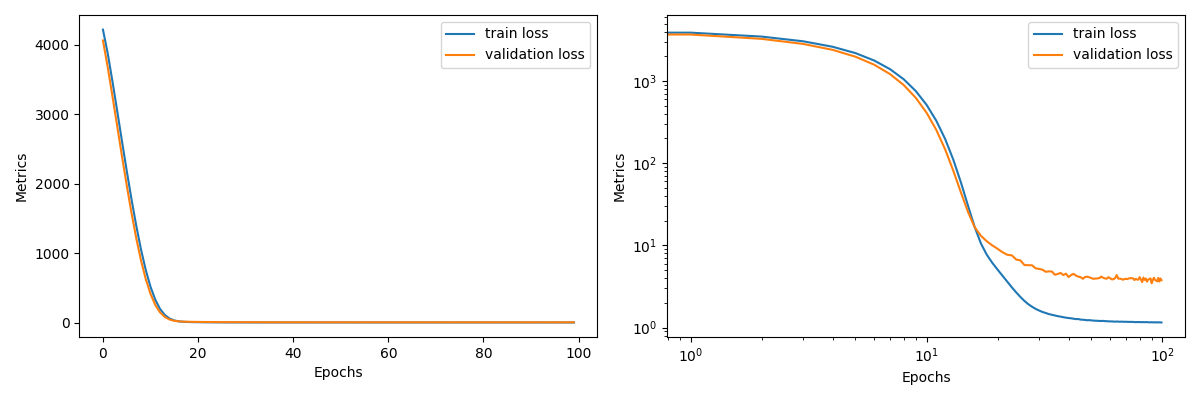

In [21]:
# Load plot (image) of FP32 history
from IPython.display import Image
Image(filename='/home/ttahmid/applications_test/tf-melt/examples/results/fp32_history.png')

### Importing Plot History for BF16 BNN Training

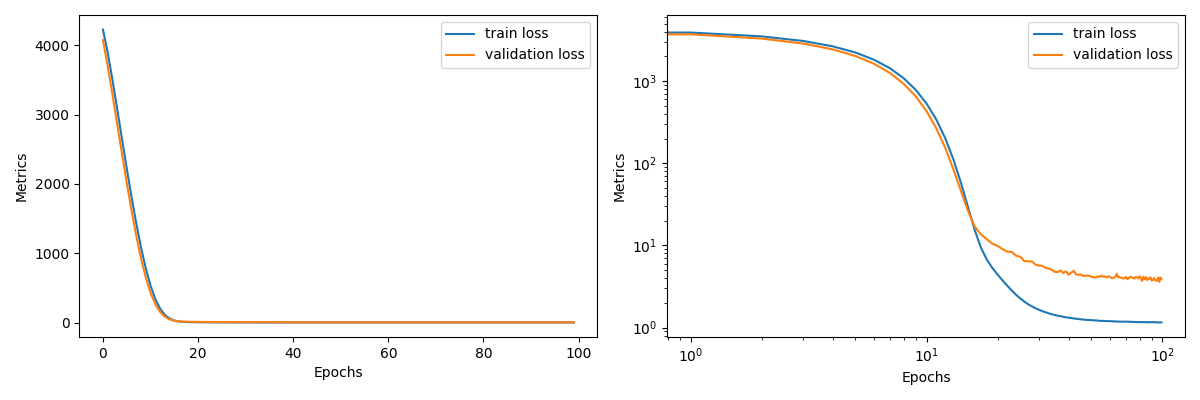

In [22]:
# Load plot (image) of FP32 history
from IPython.display import Image
Image(filename='/home/ttahmid/applications_test/tf-melt/examples/results/bf16_history.png')